In [ ]:
import pandas as pd
import numpy as np

import keras
from keras.preprocessing.image import ImageDataGenerator, image
from keras.applications import mobilenet_v2
from keras import layers
from keras import models
from tensorflow.keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

import math
from sklearn.metrics import confusion_matrix, classification_report

import glob
import os
from pathlib import Path
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/modeltwo/train'
validation_dir = '/content/drive/MyDrive/modeltwo/validation'
test_dir = '/content/drive/MyDrive/modeltwo/test'

## First Model Run

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=30,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (30, 150, 150, 3)
labels batch shape: (30,)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=10)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 245s 12s/step - loss: 0.7005 - acc: 0.5073 - val_loss: 0.6772 - val_acc: 0.6000
Epoch 2/30
20/20 [==============================] - 122s 6s/step - loss: 0.6566 - acc: 0.6068 - val_loss: 0.6457 - val_acc: 0.6950
Epoch 3/30
20/20 [==============================] - 79s 4s/step - loss: 0.6313 - acc: 0.6595 - val_loss: 0.6238 - val_acc: 0.5850
Epoch 4/30
20/20 [==============================] - 64s 3s/step - loss: 0.6020 - acc: 0.6863 - val_loss: 0.6715 - val_acc: 0.6650
Epoch 5/30
20/20 [==============================] - 59s 3s/step - loss: 0.6170 - acc: 0.6566 - val_loss: 0.6093 - val_acc: 0.6750
Epoch 6/30
20/20 [==============================] - 55s 3s/step - loss: 0.5885 - acc: 0.6848 - val_loss: 0.5676 - val_acc: 0.6850
Epoch 7/30
20/20 [==============================] - 52s 3s/step - loss: 0.5563 - acc: 0.7177 - val_loss: 0.6435 - val_acc: 0.5900
Epoch 8/30
20/20 [==============================] - 52s 3s/step - loss: 0.5844 - acc: 0

In [ ]:
model.save('taketwo_one.h5')

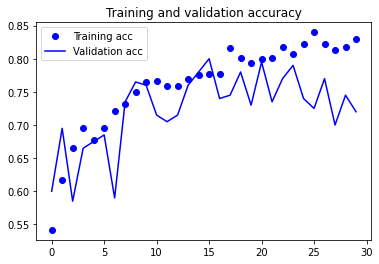

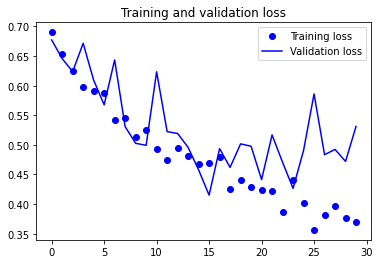

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Second Model Run with Image Augmentation and Dropout

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='wrap')

In [ ]:
train_sur_dir = '/content/drive/MyDrive/modeltwo/train/surrealism'
train_neo_dir = '/content/drive/MyDrive/modeltwo/train/neoclassicism'

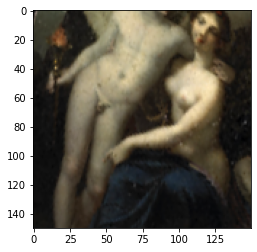

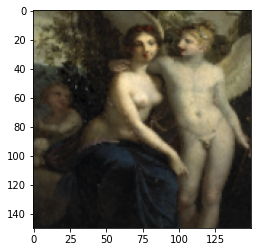

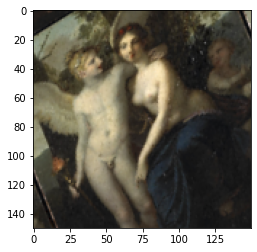

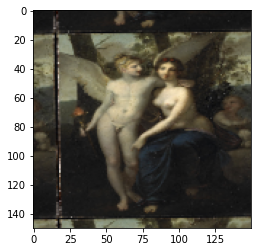

In [ ]:
fnames = [os.path.join(train_neo_dir, fname) for fname in os.listdir(train_neo_dir)]

# We pick one image to "augment"
img_path = fnames[2]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='wrap')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=30,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=10)

Found 1200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 59s 3s/step - loss: 24.0681 - acc: 0.5230 - val_loss: 0.6897 - val_acc: 0.6550
Epoch 2/30
20/20 [==============================] - 56s 3s/step - loss: 1.9683 - acc: 0.5948 - val_loss: 0.6908 - val_acc: 0.6450
Epoch 3/30
20/20 [==============================] - 57s 3s/step - loss: 1.1270 - acc: 0.5894 - val_loss: 0.6911 - val_acc: 0.5850
Epoch 4/30
20/20 [==============================] - 55s 3s/step - loss: 0.7576 - acc: 0.6110 - val_loss: 0.6920 - val_acc: 0.6450
Epoch 5/30
20/20 [==============================] - 57s 3s/step - loss: 0.7433 - acc: 0.6205 - val_loss: 0.6919 - val_acc: 0.6000
Epoch 6/30
20/20 [==============================] - 55s 3s/step - loss: 0.7590 - acc: 0.5900 - val_loss: 0.6920 - val_acc: 0.6550
Epoch 7/30
20/20 [==============================] - 56s 3s/step - loss: 0.6665 - acc: 0.6604 - val_loss: 0.6917 - val_acc: 0.5850
Epoch 8/30
20/20 [==============================] - 57s 3s/step - loss: 0.6207 - acc: 0.6

In [ ]:
model.save('taketwo_two.h5')


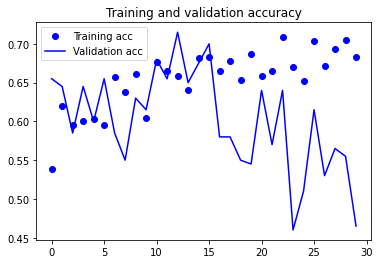

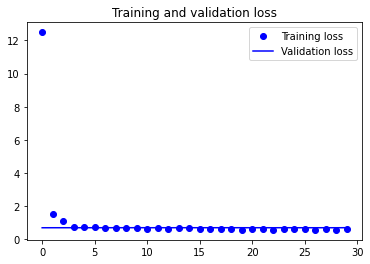

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Trying Just Dropout -- Augmentation is Awful

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=10)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 55s 3s/step - loss: 0.7371 - acc: 0.5330 - val_loss: 0.6997 - val_acc: 0.4950
Epoch 2/30
20/20 [==============================] - 52s 3s/step - loss: 0.6648 - acc: 0.5787 - val_loss: 0.6088 - val_acc: 0.6350
Epoch 3/30
20/20 [==============================] - 52s 3s/step - loss: 0.5935 - acc: 0.6837 - val_loss: 0.6080 - val_acc: 0.6700
Epoch 4/30
20/20 [==============================] - 54s 3s/step - loss: 0.6159 - acc: 0.6329 - val_loss: 0.6082 - val_acc: 0.6350
Epoch 5/30
20/20 [==============================] - 53s 3s/step - loss: 0.5457 - acc: 0.7107 - val_loss: 0.5557 - val_acc: 0.7050
Epoch 6/30
20/20 [==============================] - 51s 3s/step - loss: 0.5370 - acc: 0.7358 - val_loss: 0.5412 - val_acc: 0.6950
Epoch 7/30
20/20 [==============================] - 54s 3s/step - loss: 0.5160 - acc: 0.7102 - val_loss: 0.5675 - val_acc: 0.7200
Epoch 8/30
20/20 [==============================] - 54s 3s/step - loss: 0.5322 - acc: 0.71

In [ ]:
model.save('taketwo_three.h5')


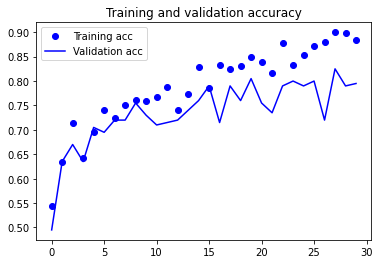

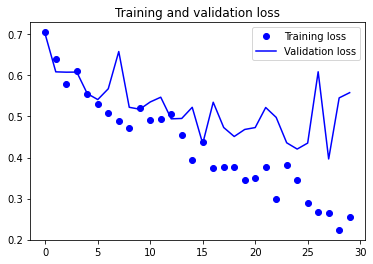

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()